In [66]:
import pandas as pd
import numpy as np

import time

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import xgboost as xgb
from xgboost import XGBClassifier

import shap

## 1.  Model - No filter selection

#### 1. Load dataset 

In [67]:
df = pd.read_csv("./dataset/data-t1.csv")

In [68]:
print(df.shape)
df.head()

(569, 33)


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


#### 2. Clean dataset 

In [69]:
x = df.drop(columns=['diagnosis', 'id', 'Unnamed: 32'])
y = df['diagnosis'].map({"M": 0, "B": 1})

print(x.shape)

(569, 30)


#### 3. Train Model

In [70]:
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.7)

model = XGBClassifier()
start = time.time()
model.fit(x_train, y_train)
stop = time.time()

print(f"Training time: {(stop - start) * 1000 }ms")

[18:56:43] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training time: 102.01907157897949ms


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


#### 4. Model Results

## 2. Apply Feature Selection (Shap)

In [71]:
shap.initjs()

explainer = shap.Explainer(model)

start = time.time()
shap_values = explainer.shap_values(x_train)
stop = time.time()

print(f"Training time: {(stop - start) * 1000 }ms")

Training time: 7.761955261230469ms


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [72]:
import matplotlib.pyplot as plt

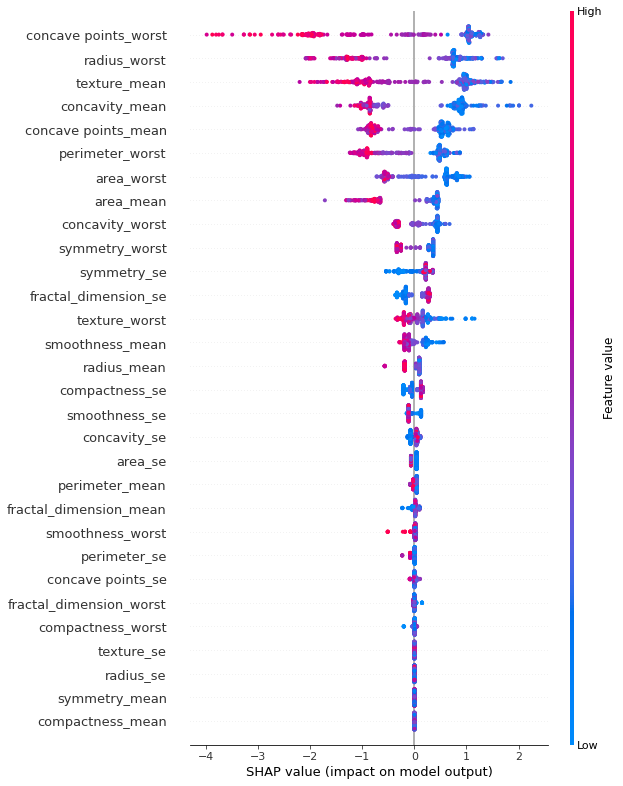

In [73]:
shap.summary_plot(shap_values, x_train, max_display=len(x.columns))

In [74]:
vals= np.abs(shap_values).mean(0)
feature_importance = pd.DataFrame(list(zip(x_train.columns, vals)),columns=['feature_name','importance_value'])
feature_importance.sort_values(by=['importance_value'],ascending=False,inplace=True)

print(feature_importance.to_latex())

\begin{tabular}{llr}
\toprule
{} &             feature\_name &  importance\_value \\
\midrule
27 &     concave points\_worst &          1.294864 \\
20 &             radius\_worst &          0.979955 \\
1  &             texture\_mean &          0.977831 \\
6  &           concavity\_mean &          0.891790 \\
7  &      concave points\_mean &          0.655716 \\
22 &          perimeter\_worst &          0.647062 \\
23 &               area\_worst &          0.581877 \\
3  &                area\_mean &          0.525585 \\
26 &          concavity\_worst &          0.333515 \\
28 &           symmetry\_worst &          0.315694 \\
18 &              symmetry\_se &          0.230763 \\
19 &     fractal\_dimension\_se &          0.218302 \\
21 &            texture\_worst &          0.194439 \\
4  &          smoothness\_mean &          0.167615 \\
0  &              radius\_mean &          0.121043 \\
15 &           compactness\_se &          0.116896 \\
14 &            smoothness\_se &         

In [75]:
import os

measures_data = []
featured_names = []

def print_classification_report(classification_report):
    accuracy = classification_report["accuracy"]
    precision = classification_report["weighted avg"]["precision"]
    f1_score = classification_report["weighted avg"]["f1-score"]
    recall = classification_report["weighted avg"]["recall"]
    
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"F1 Score: {f1_score}")
    print(f"Recall: {recall}")
    print(f"Training time: {(stop - start) * 1000 }s")

def get_measures(feature, classification_report, training_time, shap_value, storage): 
    accuracy = classification_report["accuracy"]
    precision = classification_report["weighted avg"]["precision"]
    f1_score = classification_report["weighted avg"]["f1-score"]
    recall = classification_report["weighted avg"]["recall"]
    
    measures_data.append([feature, accuracy, precision, recall, f1_score, training_time, shap_value, storage])

def train_model(feature, shap_value):
    featured_names.append(feature)
    x = df[featured_names]
    y = df['diagnosis'].map({"M": 0, "B": 1})
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.7)

    model = XGBClassifier()
    start = time.time()
    model.fit(x_train, y_train)
    stop = time.time()
    
    predict = model.predict(x_test)
    
    storage = get_storage(featured_names)
    training_time = (stop - start) * 1000
    classification = classification_report(y_test, predict, output_dict=True)
    get_measures(feature, classification, training_time, shap_value, storage)
    
def get_storage(features):
    merged_features = ['diagnosis', 'id', 'Unnamed: 32'] + features
    temp = df[merged_features]
    temp.to_csv('./dataset/temp.csv')
    
    return os.stat('./dataset/temp.csv').st_size
            
def shap_all(df):
    for index, row in df.iterrows():
        train_model(row['feature_name'], row['importance_value'])

In [76]:
shap_all(feature_importance)

measures_df = pd.DataFrame(measures_data, columns = ['Feature Name', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'Training Time', 'Shap Value', 'Storage'])

measures_df.to_csv('./results/xgboost/cancer-breast-xgboost-report.csv')

[18:56:45] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[18:56:45] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:56:45] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory co

[18:56:45] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:56:45] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:56:45] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warnin

[18:56:45] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:56:45] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory co

[18:56:46] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:56:46] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:56:46] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory co

[18:56:46] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:56:46] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:56:46] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory co

[18:56:46] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:56:46] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:56:46] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory co

[18:56:46] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:56:46] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:56:46] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:56:46] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory co

[18:56:46] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:56:47] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:56:47] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory co

[18:56:47] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:56:47] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:56:47] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory co

[18:56:47] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:56:47] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:56:47] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption


In [77]:
measures_df.head()

,Feature Name,Accuracy,Precision,Recall,F1 Score,Training Time,Shap Value,Storage
0,concave points_worst,0.865497,0.865191,0.865497,0.865313,246.060133,1.294864,12290
1,radius_worst,0.923977,0.924238,0.923977,0.924075,129.853964,0.979955,15662
2,texture_mean,0.947368,0.947416,0.947368,0.947073,72.329998,0.977831,19037
3,concavity_mean,0.964912,0.964912,0.964912,0.964912,105.997801,0.891790,23315
4,concave points_mean,0.953216,0.953216,0.953216,0.953216,61.447859,0.655716,27748


In [78]:
import matplotlib.pyplot as plt

# Performance

def show_accuracy_chart(df):
    temp_1 = df['Accuracy'].tolist()
    temp_2 = list(range(1,31))
    plt.xlabel("Number of features")
    plt.ylabel("Accuracy (%)")
    plt.plot(temp_2, temp_1)
    plt.savefig('./results/xgboost/xgboost-accuracy.png')
    
def show_precision_chart(df):
    temp_1 = df['Precision'].tolist()
    temp_2 = list(range(1,31))
    plt.xlabel("Number of features")
    plt.ylabel("Precision (%)")
    plt.plot(temp_2, temp_1)
    plt.savefig('./results/xgboost/xgboost-precision.png')
    
def show_recall_chart(df):
    temp_1 = df['Recall'].tolist()
    temp_2 = list(range(1,31))
    plt.xlabel("Number of features")
    plt.ylabel("Recall (%)")
    plt.plot(temp_2, temp_1)
    plt.savefig('./results/xgboost/xgboost-recall.png')
    
def show_f1_score_chart(df):
    temp_1 = df['F1 Score'].tolist()
    temp_2 = list(range(1,31))
    plt.xlabel("Number of features")
    plt.ylabel("F1 Score (%)")
    plt.plot(temp_2, temp_1)
    plt.savefig('./results/xgboost/xgboost-f1-score.png')
    
# Storage
    
def show_storage_chart(df):
    temp_1 = df['Storage'].tolist()
    temp_2 = list(range(1,31))
    plt.xlabel("Number of features")
    plt.ylabel("Storage (bytes)")
    plt.plot(temp_2, temp_1)
    plt.savefig('./results/xgboost/xgboost-storage.png')
    
# Training Time
    
def show_training_chart(df):
    temp_1 = df['Training Time'].tolist()
    temp_2 = list(range(1,31))
    plt.xlabel("Number of features")
    plt.ylabel("Time (ms)")
    plt.plot(temp_2, temp_1)
    plt.savefig('./results/xgboost/xgboost-training-time.png')

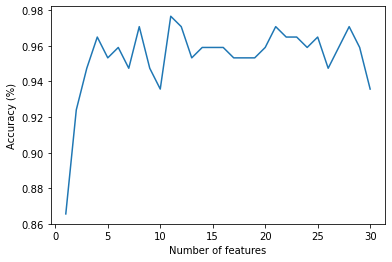

In [79]:
show_accuracy_chart(measures_df)

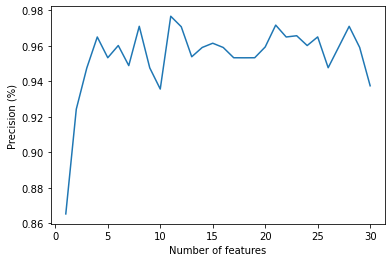

In [80]:
show_precision_chart(measures_df)

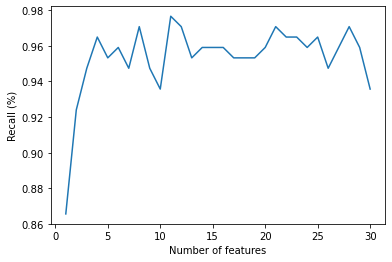

In [81]:
show_recall_chart(measures_df)

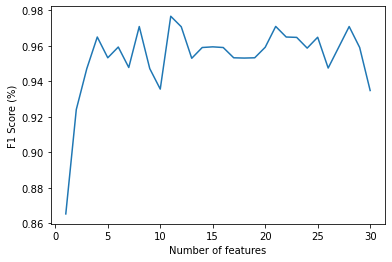

In [82]:
show_f1_score_chart(measures_df)

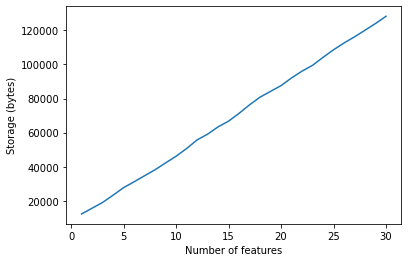

In [83]:
show_storage_chart(measures_df)

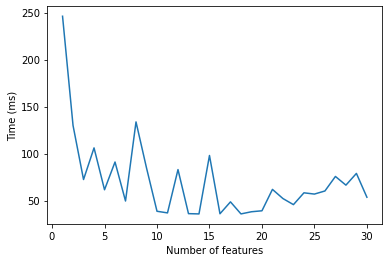

In [84]:
show_training_chart(measures_df)